# Avaliação e seleção de modelos 

- conjuntos de dados
- busca de hiperparâmetros
- avaliação


## 1. Introdução

### 1.1. Treinamento e teste

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part1/testing.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>


### 1.2. Treinamento, validação e teste</h2>

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

### 1.3. Validação cruzada

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold.png" alt="Drawing" style="width: 600px;"/> </td></tr>
</table>

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import argparse

import sys
import theano
import keras
import sklearn
from keras.models import Sequential, load_model, Model
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.regularizers import l2

from keras.optimizers import SGD
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils

print 'Keras:  ', keras.__version__
print 'Theano: ', theano.__version__
print 'Numpy:  ', np.__version__
print 'Sklearn:', sklearn.__version__

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Keras:   1.2.0
Theano:  0.8.2
Numpy:   1.11.3
Sklearn: 0.18.1


In [3]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier

counter = 0

class MyKerasClassifier(KerasClassifier):

    def get_params(self, deep=True):
        return super(MyKerasClassifier, self).get_params(deep)

    def fit(self, X, y, **kwargs):
        global counter
        t0 = time.time()
        
        print '{:3d}: {}'.format(counter, self.filter_sk_params(self.build_fn)),
        sys.stdout.flush()
        counter += 1
                
        kw = dict(callbacks=[ModelCheckpoint('gg.model', save_best_only=True), 
                             EarlyStopping(patience=15, verbose=0)])
        kw.update(kwargs)
        
        hh = super(MyKerasClassifier, self).fit(X, y, **kw)
        self.model = load_model('gg.model')
        
        et = time.time() - t0
        print ' [{:.1f}s]'.format(et)
        return hh
        
    def score(self, X, y, **kwargs):
        score = super(MyKerasClassifier, self).score(X, y, **kwargs)
        print '     score: {}'.format(score)
        return score
    
def make_model(lr=0.01, momentum=0.9, dropout=0.5):
    model = SmallFCNet.build(width=784, classes=10, dropout=dropout)
    optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    
    return model


In [4]:
def train_network(optimizer, X_train, y_train, X_test, y_test, dropout=0.5, nepochs=50, ploss=0.25):
    print("[INFO] creating model...")
    model = SmallFCNet.build(width=784, classes=10, dropout=dropout)

    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])    

    fig = plot.figure(figsize=(15,6))
    plot.ylim(0.0, ploss)
    plot.xlim(0, nepochs)
    plot.grid(True)

    print("[INFO] training...")
    try:
        histo2 = model.fit(X_train, y_train, batch_size=128, nb_epoch=nepochs, 
                           verbose=0, validation_split=0.33, callbacks=[histo])
    except KeyboardInterrupt:
        pass

    print("[INFO] evaluating...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))
    
    return model, histo


In [5]:
class SmallFCNet:
    @staticmethod
    def build(width, classes, dropout):
        model = Sequential()        
        model.add(Dense(1000, input_dim=width))
        model.add(Activation("relu"))
        model.add(Dropout(dropout))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model


## 2. Conjuntos de dados

- Treinamento 
- Validação
- Testes

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_01.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


In [6]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (TrainingPlotter)

(X_train, y_train_), (X_test, y_test_) = mnist.load_data()

X_train_all = X_train.reshape(-1, 28*28) / 255.0
X_test = X_test.reshape(-1, 28*28) / 255.0

y_train_all = np_utils.to_categorical(y_train_, 10)
y_test = np_utils.to_categorical(y_test_, 10)

# X_train, y_train = X_train_all[:15000], y_train_all[:15000]
X_train, y_train = X_train_all, y_train_all

print X_train.shape, X_test.shape
print y_train.shape, y_test.shape

# determina índices para os conjuntos de teste e validação
nn = X_train.shape[0]
ii = nn / 3
ii_trn, ii_val = np.arange(2*ii), np.arange(2*ii, nn)
print 'índices para o treinamento:', ii_trn
print 'índices para a validação:', ii_val

(60000, 784) (10000, 784)
(60000, 10) (10000, 10)
índices para o treinamento: [    0     1     2 ..., 39997 39998 39999]
índices para a validação: [40000 40001 40002 ..., 59997 59998 59999]


## 3. Grid-search

### 3.1. Sintonia de hiperparâmetros

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_02.png" alt="Drawing" style="width: 800px;"/> </td></tr>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_03.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


In [7]:
counter = 0
my_classifier = MyKerasClassifier(make_model, batch_size=128, nb_epoch=50, verbose=0)

param_grid = {
    'lr': [0.01, 0.05, 0.1],
    'momentum': [0.9, 0.999],
    'dropout': [0.2, 0.5, 0.7],
}

validator = GridSearchCV(my_classifier, 
                         param_grid=param_grid, 
                         cv=[(ii_trn, ii_val)],
                         fit_params=dict(validation_data=(X_train[ii_val], y_train[ii_val])))

try:
    validator.fit(X_train, y_train)
    print
except KeyboardInterrupt:
    pass
else:
    print 'The parameters of the best model are: ', validator.best_params_


  0: {'dropout': 0.2, 'lr': 0.01, 'momentum': 0.9}  [75.0s]
     score: 0.97715
     score: 0.998975
  1: {'dropout': 0.2, 'lr': 0.01, 'momentum': 0.999}  [28.8s]
     score: 0.94725
     score: 0.957025
  2: {'dropout': 0.2, 'lr': 0.05, 'momentum': 0.9}  [50.9s]
     score: 0.97925
     score: 0.999825
  3: {'dropout': 0.2, 'lr': 0.05, 'momentum': 0.999}  [27.1s]
     score: 0.826
     score: 0.826025
  4: {'dropout': 0.2, 'lr': 0.1, 'momentum': 0.9}  [39.2s]
     score: 0.978
     score: 0.998875
  5: {'dropout': 0.2, 'lr': 0.1, 'momentum': 0.999}  [27.4s]
     score: 0.51975
     score: 0.508075
  6: {'dropout': 0.5, 'lr': 0.01, 'momentum': 0.9}  [75.8s]
     score: 0.97815
     score: 0.998025
  7: {'dropout': 0.5, 'lr': 0.01, 'momentum': 0.999}  [28.8s]
     score: 0.9515
     score: 0.95925
  8: {'dropout': 0.5, 'lr': 0.05, 'momentum': 0.9}  [56.9s]
     score: 0.9798
     score: 0.999375
  9: {'dropout': 0.5, 'lr': 0.05, 'momentum': 0.999}  [27.3s]
     score: 0.78905
     score

### 3.2. Avaliação de desempenho

<table align='left'>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_04.png" alt="Drawing" style="width: 800px;"/> </td></tr>
<tr><td> <img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/holdout-validation_05.png" alt="Drawing" style="width: 800px;"/> </td></tr>
</table>


[INFO] evaluating...
 9856/10000 [============================>.] - ETA: 0s[INFO] accuracy: 98.34%


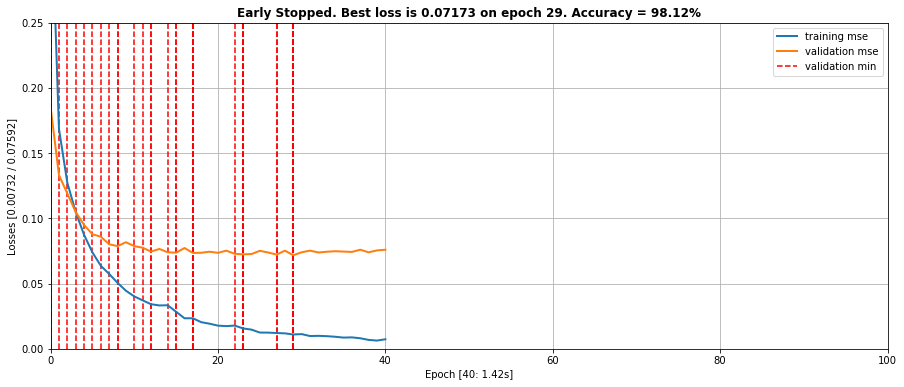

In [8]:
best = validator.best_params_
lr = best['lr']
momentum = best['momentum']
dropout = best['dropout']
optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
model, histo = train_network(optimizer, X_train_all, y_train_all, X_test, y_test, 
                             dropout=dropout, nepochs=100, ploss=0.25)

## 4. Random search

### 4.1. Sintonia de hiperparâmetros

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [9]:
import scipy.stats as st

counter = 0
my_classifier = MyKerasClassifier(make_model, batch_size=128, nb_epoch=50, verbose=0)

param_dist={
    'lr':       st.uniform(0.001, 0.4),
    'momentum': st.uniform(0.9, 0.099),
    'dropout':  [0.2, 0.5, 0.7],
}
validator = RandomizedSearchCV(my_classifier, 
                               param_distributions=param_dist, 
                               n_iter=20,
                               cv=[(ii_trn, ii_val)],
                               fit_params=dict(validation_data=(X_train[ii_val], y_train[ii_val])),
                              )

try:
    validator.fit(X_train, y_train)
    print
except KeyboardInterrupt:
    pass
else:
    print 'The parameters of the best model are: ', validator.best_params_


  0: {'dropout': 0.2, 'lr': 0.038158940899374931, 'momentum': 0.91782270426201584}  [44.3s]
     score: 0.97745
     score: 0.998475
  1: {'dropout': 0.2, 'lr': 0.21227353852710479, 'momentum': 0.95057413405459468}  [32.6s]
     score: 0.9617
     score: 0.978675
  2: {'dropout': 0.2, 'lr': 0.15164488083555064, 'momentum': 0.95128023432173148}  [36.9s]
     score: 0.96885
     score: 0.988
  3: {'dropout': 0.7, 'lr': 0.097234429970290068, 'momentum': 0.90067270989274495}  [58.3s]
     score: 0.9788
     score: 0.99485
  4: {'dropout': 0.7, 'lr': 0.010045246816194918, 'momentum': 0.91281808731639291}  [74.3s]
     score: 0.97855
     score: 0.996775
  5: {'dropout': 0.2, 'lr': 0.082116531698488981, 'momentum': 0.9250058469879231}  [35.4s]
     score: 0.97715
     score: 0.99705
  6: {'dropout': 0.7, 'lr': 0.11824799346847248, 'momentum': 0.90293573910764224}  [49.6s]
     score: 0.9744
     score: 0.99025
  7: {'dropout': 0.7, 'lr': 0.18916888632428341, 'momentum': 0.97634178770300084} 

### 4.2. Avaliação de desempenho


[INFO] evaluating...
 9728/10000 [============================>.] - ETA: 0s[INFO] accuracy: 97.99%


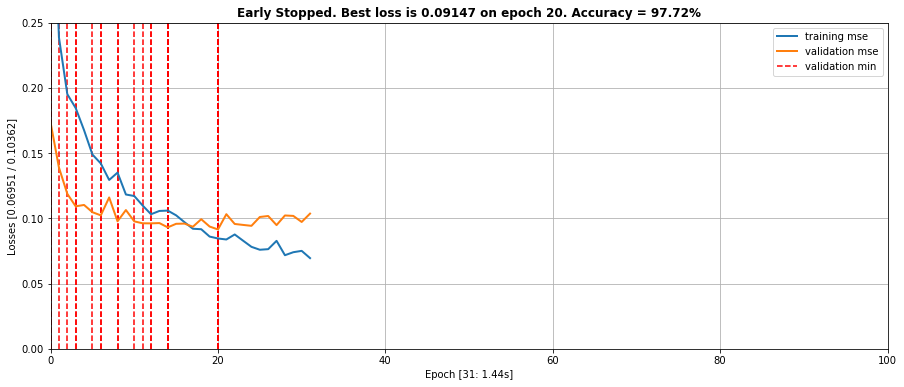

In [10]:
best = validator.best_params_
lr = best['lr']
momentum = best['momentum']
dropout = best['dropout']
optimizer = SGD(lr=lr, momentum=momentum, nesterov=True)
model, histo = train_network(optimizer, X_train_all, y_train_all, X_test, y_test, 
                             dropout=dropout, nepochs=100, ploss=0.25)